In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error

%matplotlib inline

# plt.style.use('seaborn-v0_8-colorblind')

# plt.style.use('ggplot')

2024-11-30 12:48:56.035204: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-30 12:48:56.779518: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
df = pd.read_csv("../datasets/unloaded-concorrencia-long.csv", low_memory= False)

df.head()

,time,sent,received,latency_min,latency_median,latency_75th,latency_95th,latency_99th
0,3.000,5003,5002,112,463,2074,7775,18691.0
1,4.000,4999,5001,122,308,1567,13582,29517.0
2,5.000,5005,5005,109,305,1121,6012,9508.0
3,6.000,5001,4996,119,633,1800,10002,18919.0
4,7.000,5005,5008,122,543,1352,8810,13233.0


In [4]:
df.shape

(86398, 8)

In [5]:
df = df.drop_duplicates()
df = df.reset_index(drop=True)

df.shape

(57600, 8)

In [6]:
df.latency_median = pd.to_numeric(df.latency_median, errors='coerce').fillna(0).astype(int)
df.received = pd.to_numeric(df.received, errors='coerce').fillna(0).astype(int)
df.sent = pd.to_numeric(df.sent, errors='coerce').fillna(0).astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57600 entries, 0 to 57599
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   time            57600 non-null  object 
 1   sent            57600 non-null  int64  
 2   received        57600 non-null  int64  
 3   latency_min     57600 non-null  object 
 4   latency_median  57600 non-null  int64  
 5   latency_75th    57597 non-null  object 
 6   latency_95th    57597 non-null  object 
 7   latency_99th    57595 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 3.5+ MB


In [7]:
print(df.latency_median.isna().sum())

print(np.isinf(df.latency_median).sum())

0
0


In [8]:
df.columns

Index(['time', 'sent', 'received', 'latency_min', 'latency_median',
       'latency_75th', 'latency_95th', 'latency_99th'],
      dtype='object')

In [9]:
df = df.drop(columns=['time', 'latency_min','latency_75th', 'latency_95th', 'latency_99th'])

df.head()


,sent,received,latency_median
0,5003,5002,463
1,4999,5001,308
2,5005,5005,305
3,5001,4996,633
4,5005,5008,543


In [10]:
df.columns = ['sent', 'received', 'latency']

df.head()

,sent,received,latency
0,5003,5002,463
1,4999,5001,308
2,5005,5005,305
3,5001,4996,633
4,5005,5008,543


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57600 entries, 0 to 57599
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   sent      57600 non-null  int64
 1   received  57600 non-null  int64
 2   latency   57600 non-null  int64
dtypes: int64(3)
memory usage: 1.3 MB


In [12]:
df.shape

(57600, 3)

In [13]:
df.index

RangeIndex(start=0, stop=57600, step=1)

In [14]:
latencia = df.latency

latencia.head()

0    463
1    308
2    305
3    633
4    543
Name: latency, dtype: int64

In [15]:
time = latencia.index

In [16]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(21, 7))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

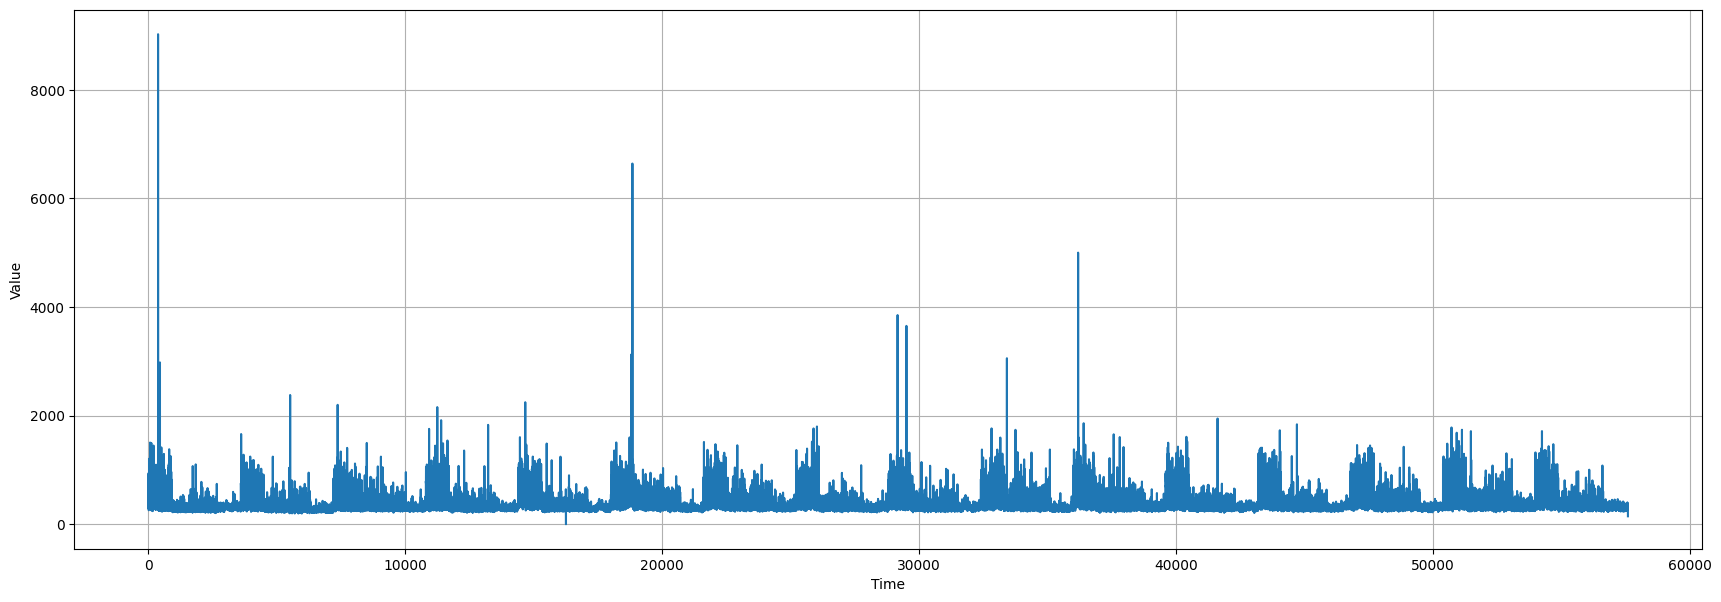

In [17]:
plot_series(time, latencia)

In [23]:
# Define the split time
# split_time = int(df.shape[0]*0.8)
split_time = 43200      # 3 horas de treino


# Get the train set 
time_train = time[:split_time]
x_train = latencia[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = latencia[split_time:]

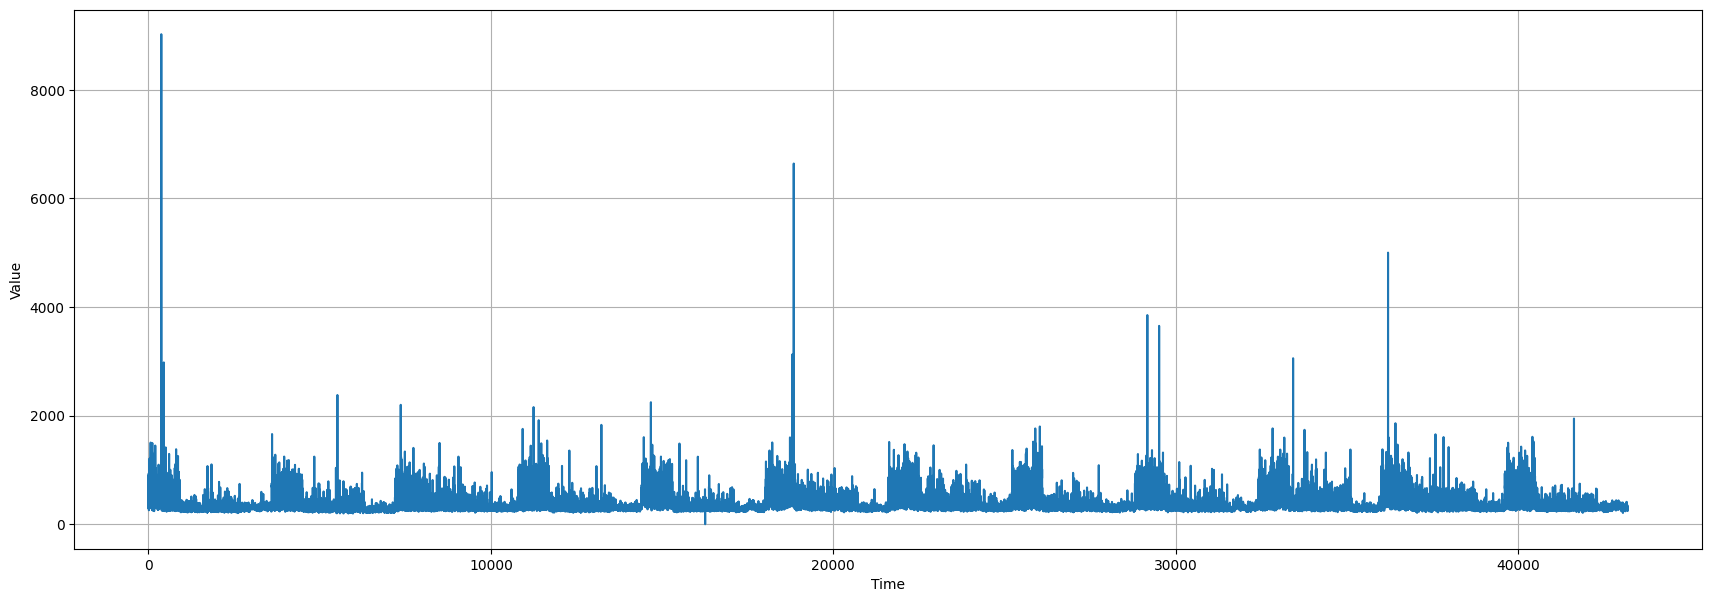

In [24]:
plot_series(time_train, x_train)

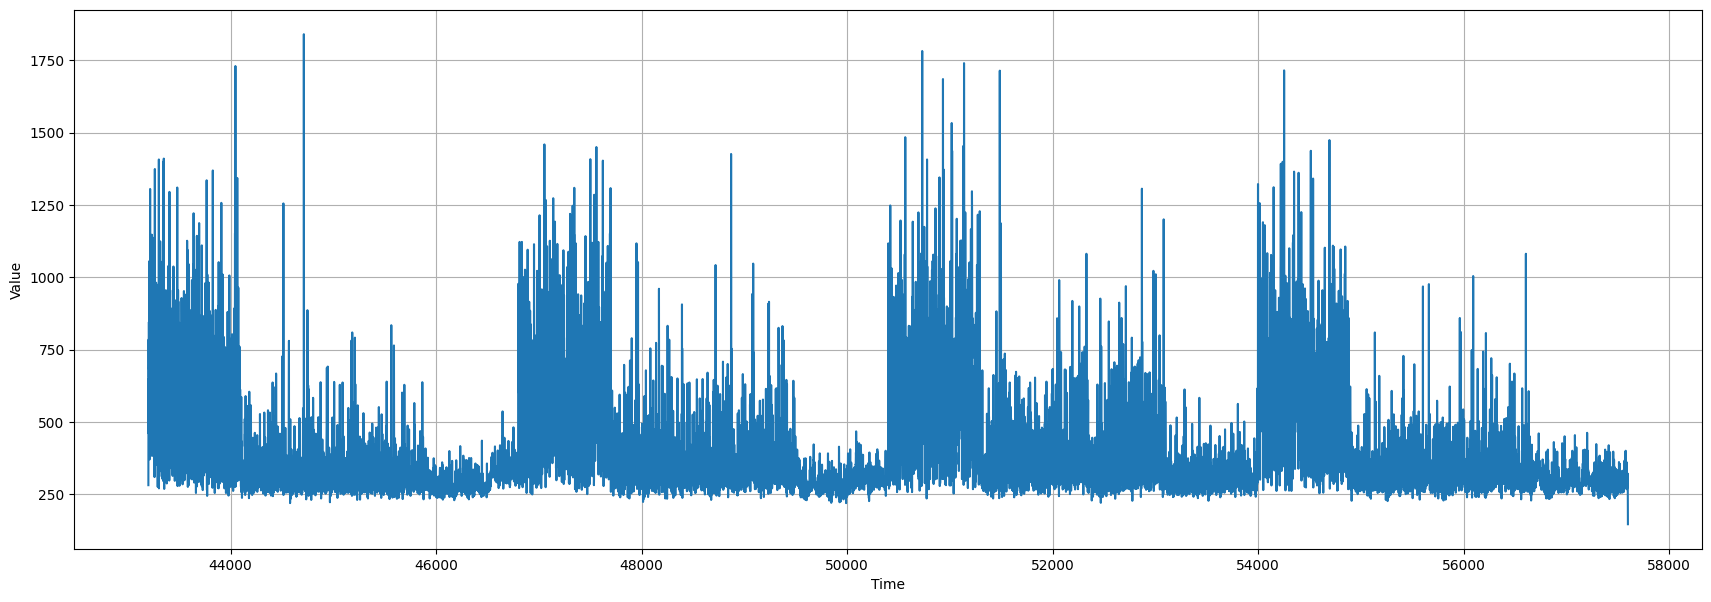

In [25]:
plot_series(time_valid, x_valid)

In [26]:
# Generate the naive forecast
naive_forecast = latencia[split_time - 1:-1]

# Define time step
time_step = 46000

# Print values
print(f'ground truth at time step {time_step}: {x_valid[time_step]}')
print(f'prediction at time step {time_step + 1}: {naive_forecast[time_step + 1]}')

ground truth at time step 46000: 267
prediction at time step 46001: 287


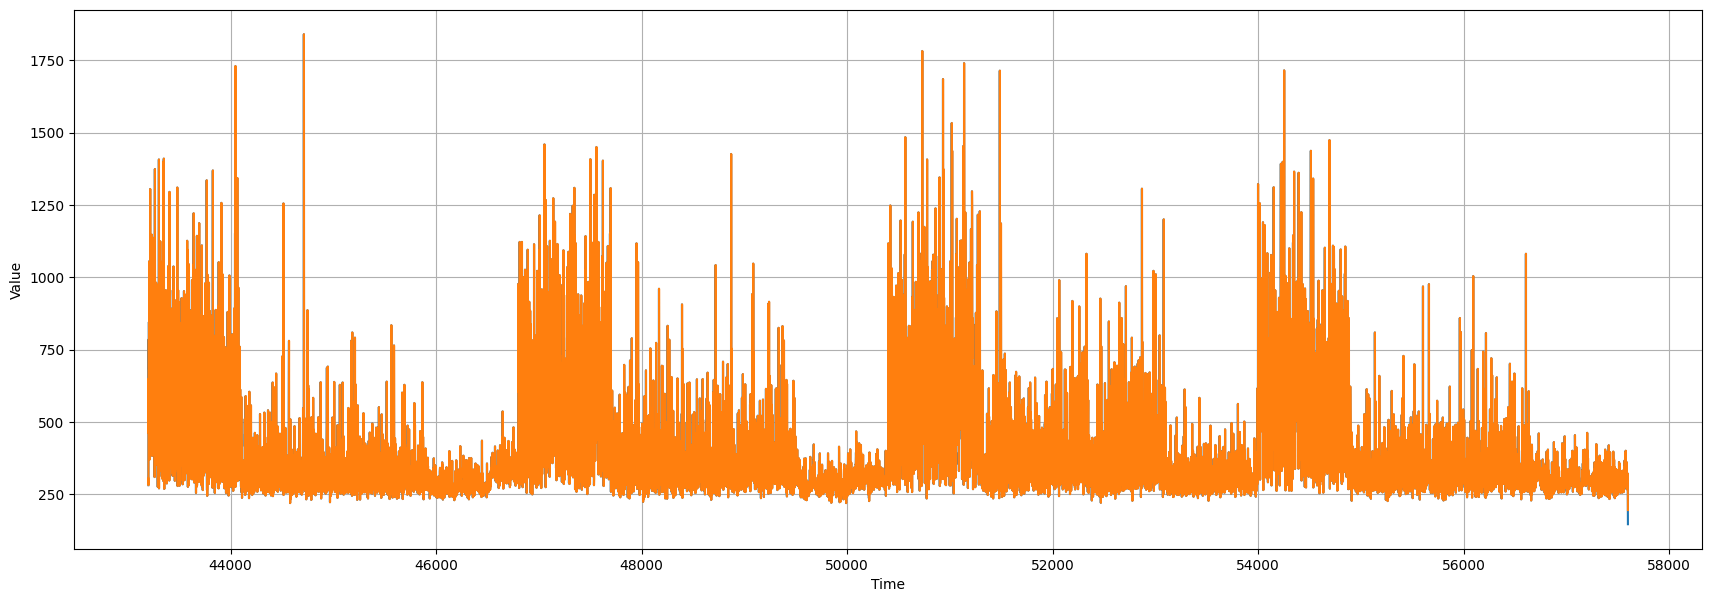

In [27]:
plot_series(time_valid, (x_valid, naive_forecast))

In [1]:
plot_series(time_valid, (x_valid, naive_forecast), start=1, end=101)

NameError: name 'plot_series' is not defined

In [29]:
print(tf.keras.metrics.mse(x_valid, naive_forecast).numpy())
print(tf.keras.metrics.mae(x_valid, naive_forecast).numpy())

31293.857
106.79972


2024-11-30 12:57:25.669594: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-30 12:57:25.714928: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [25]:
def moving_average_forecast(series, window_size):
    """Generates a moving average forecast

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to compute the average for

    Returns:
      forecast (array of float) - the moving average forecast
    """

    # Initialize a list
    forecast = []
    
    # Compute the moving average based on the window size
    for time in range(len(series) - window_size):
      forecast.append(series[time:time + window_size].mean())
    
    # Convert to a numpy array
    forecast = np.array(forecast)

    return forecast

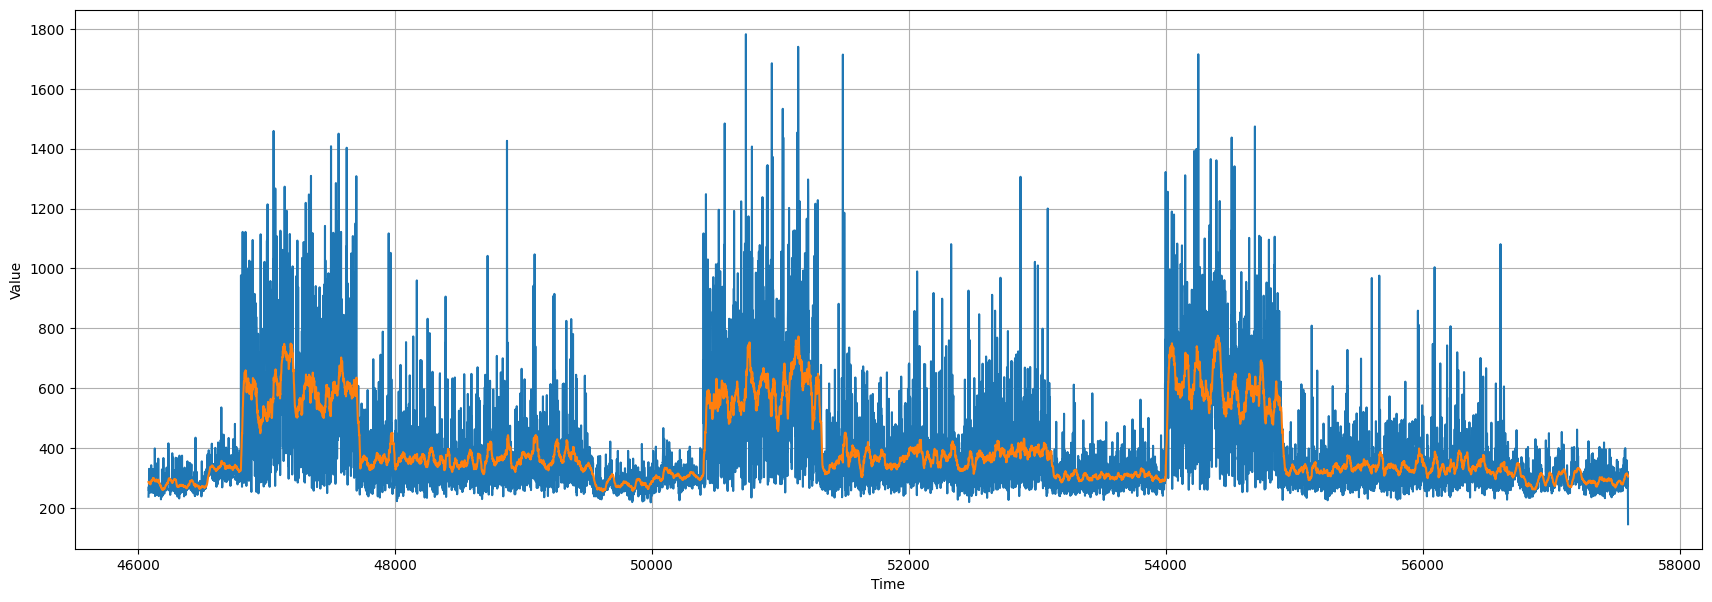

In [33]:
# Generate the moving average forecast
moving_avg = moving_average_forecast(latencia, 30)[split_time - 30:]

# Plot the results
plot_series(time_valid, (x_valid, moving_avg))

In [27]:
# Compute the metrics
print(tf.keras.metrics.mse(x_valid, moving_avg).numpy())
print(tf.keras.metrics.mae(x_valid, moving_avg).numpy())

17986.381174093363
83.0920457175926


diff_time shape: (43200,)
diff_series shape: (43200,)


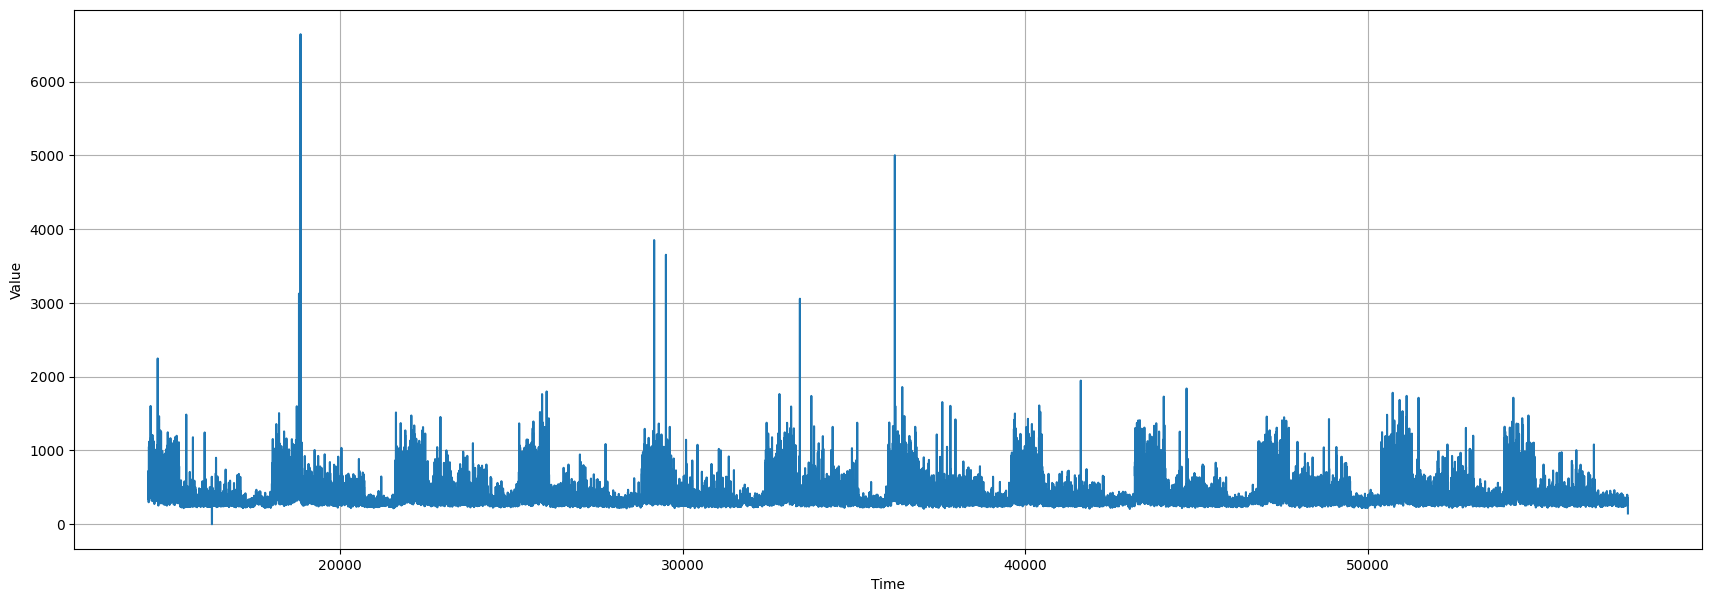

In [32]:
# Subtract the values at t-365 from original series
diff_series = (latencia[14400:])

# Truncate the first 365 time steps
diff_time = time[14400:]

print(f"diff_time shape: {diff_time.shape}")
print(f"diff_series shape: {diff_series.shape}")

# Plot the results
plot_series(diff_time, diff_series)

ValueError: x and y must have same first dimension, but have shapes (11520,) and (0,)

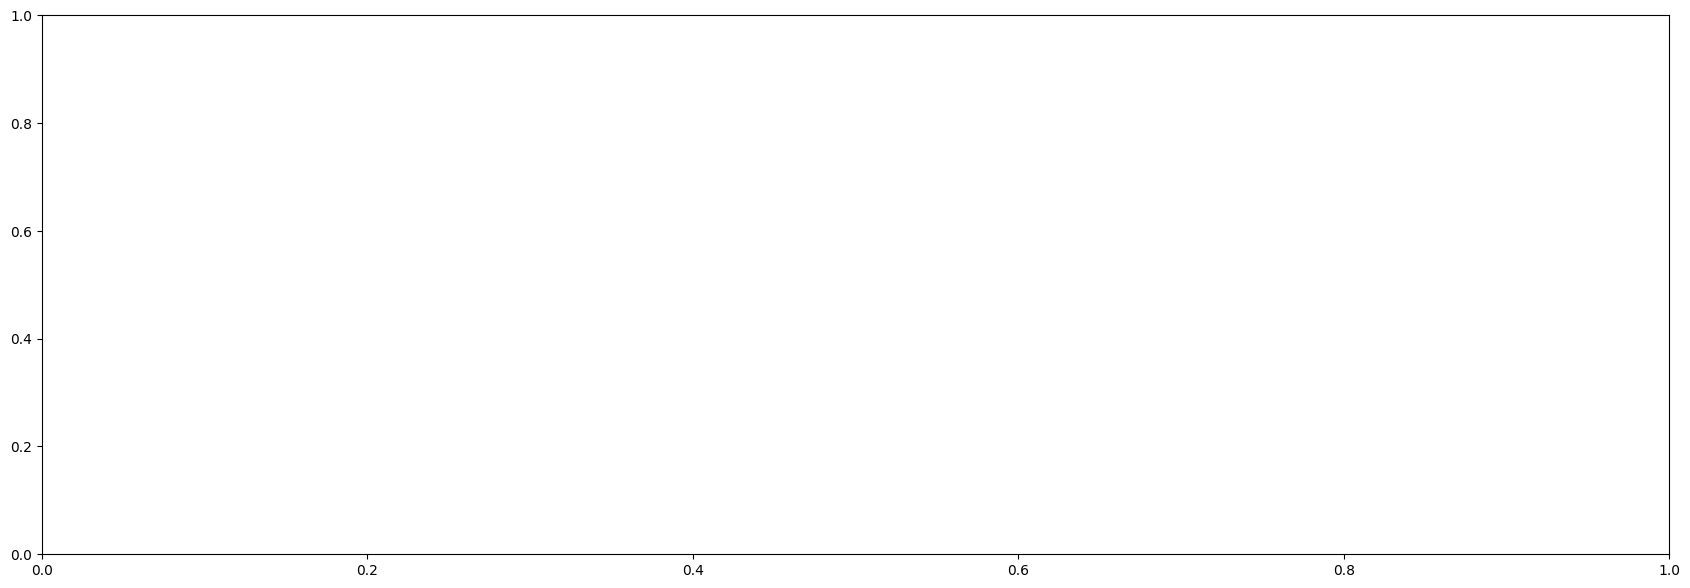

In [29]:
# Generate moving average from the time differenced dataset
diff_moving_avg = moving_average_forecast(diff_series, 30)

# Slice the prediction points that corresponds to the validation set time steps
diff_moving_avg = diff_moving_avg[split_time - 365 - 30:]

# Slice the ground truth points that corresponds to the validation set time steps
diff_series = diff_series[split_time - 365:]

# Plot the results
plot_series(time_valid, (diff_series, diff_moving_avg))

In [30]:
# Add the trend and seasonality from the original series
diff_moving_avg_plus_past = latencia[split_time - 365:-365] + diff_moving_avg

# Plot the results
plot_series(time_valid, (x_valid, diff_moving_avg_plus_past))

ValueError: operands could not be broadcast together with shapes (11520,) (0,) 

In [31]:
print(tf.keras.metrics.mse(x_valid, diff_moving_avg_plus_past).numpy())
print(tf.keras.metrics.mae(x_valid, diff_moving_avg_plus_past).numpy())

NameError: name 'diff_moving_avg_plus_past' is not defined

In [32]:
import tensorflow as tf
print("GPUs disponíveis:", len(tf.config.list_physical_devices('GPU')))

GPUs disponíveis: 0
